In [1]:
import yfinance as yf
import numpy as np
import pandas as pd


stock_data=yf.Ticker('^GSPC').history(period="max")
stock_data.dropna(inplace=True)



In [2]:
period=20
stdev=2

stock_data['rolling_mean']=stock_data['Close'].rolling(window=period).mean()
stock_data['rolling_std']=stock_data['Close'].rolling(window=period).std()

datelims=['2022-01-01','2023-12-31']
_stock_data=stock_data.loc[datelims[0]:datelims[1]]
percent_bandwidth=(_stock_data['Close']-(_stock_data['rolling_mean']-2*_stock_data['rolling_std']))/((_stock_data['rolling_mean']+2*_stock_data['rolling_std'])-(_stock_data['rolling_mean']-2*_stock_data['rolling_std']))

bandwidth=((_stock_data['rolling_mean']+2*_stock_data['rolling_std'])-(_stock_data['rolling_mean']-2*_stock_data['rolling_std']))/_stock_data['rolling_mean']


<Figure size 1000x800 with 0 Axes>

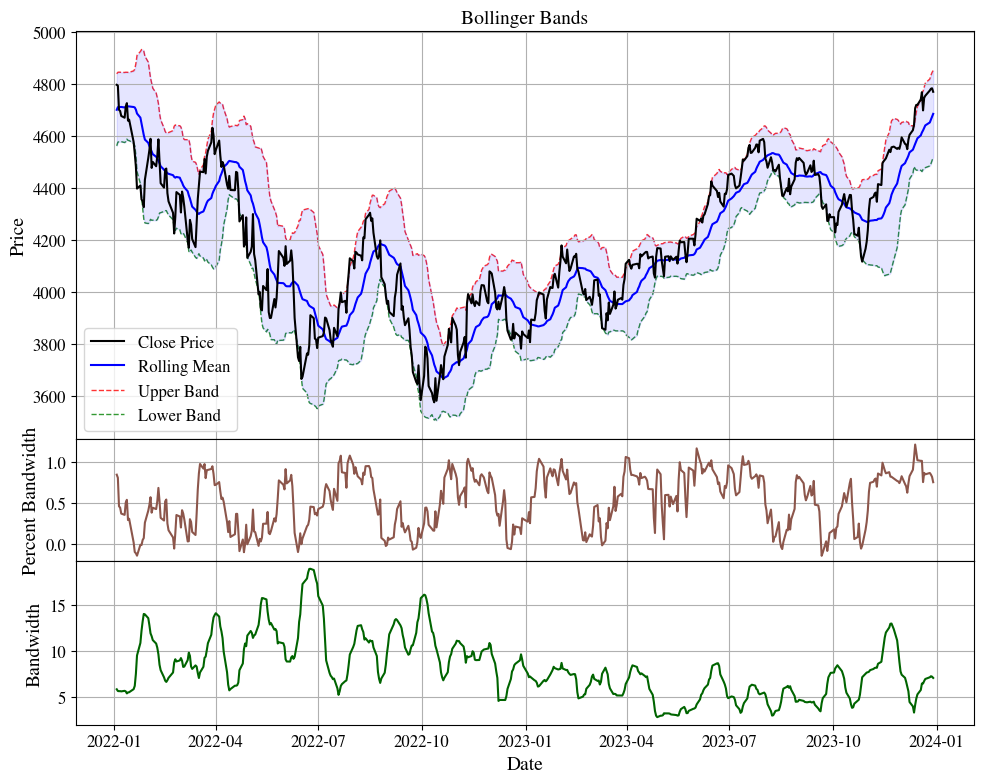

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'


SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize



fig = plt.figure(figsize=(10, 8))

fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(nrows=3, ncols=1, height_ratios=[1, 0.3, 0.4], hspace=0)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax3 = fig.add_subplot(gs[2, 0], sharex=ax1)


ax1.plot(_stock_data['Close'],label='Close Price',color='black',zorder=5)
ax1.plot(_stock_data['rolling_mean'],label='Rolling Mean',color='blue',zorder=2)
ax1.plot(_stock_data['rolling_mean']+stdev*_stock_data['rolling_std'],label='Upper Band',color='red',linestyle='--',linewidth=1,alpha=.8,zorder=0)
ax1.plot(_stock_data['rolling_mean']-stdev*_stock_data['rolling_std'],label='Lower Band',color='green',linestyle='--',linewidth=1,alpha=.8,zorder=0)
ax1.fill_between(_stock_data.index,_stock_data['rolling_mean']+stdev*_stock_data['rolling_std'],_stock_data['rolling_mean']-stdev*_stock_data['rolling_std'],color='blue',alpha=.1)
ax3.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.grid()
ax1.legend()
ax1.set_title('Bollinger Bands')


ax2.plot(percent_bandwidth,label='Percent Bandwidth',color='tab:brown',zorder=5)
ax2.set_ylabel('Percent Bandwidth')
ax2.grid()
#ax2.legend()

ax3.plot(bandwidth*100,label='Bandwidth',color='darkgreen',zorder=2)
ax3.set_ylabel('Bandwidth')
ax3.grid()
#ax3.legend()

plt.tight_layout()
plt.savefig('figures/bollinger_bands.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
keltner_period=10
_stock_data['typical_price']=(_stock_data['High']+_stock_data['Low']+_stock_data['Close'])/3
_stock_data['keltner_channel_center']=_stock_data['typical_price'].rolling(window=keltner_period).mean()
_stock_data['keltner_channel_upper']=_stock_data['keltner_channel_center']+stdev*_stock_data['typical_price'].rolling(window=keltner_period).std()